Import packages

In [1]:
import numpy as np
import time
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.applications import VGG19

from scipy.optimize import fmin_l_bfgs_b
from imageio import imwrite

import pydot
from IPython.display import display
from PIL import Image
from skimage.transform import resize

import keras.backend as K

Using TensorFlow backend.


Hyperparameters

In [0]:
content_weight = 0.025
style_weight = 1.0
total_variation_weight = 1.0

In [0]:
image_height = 512
image_width = 512

Generating image arrays from user images.

In [0]:
content_image_path = 'Content.png'
style_image_path = 'Style.png'

content_image = Image.open(content_image_path)
content_image = content_image.resize((image_width, image_height))

style_image = Image.open(style_image_path)
style_image = style_image.resize((image_width, image_height))


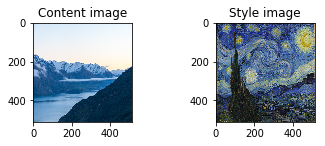

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.set_title("Content image")
ax1.imshow(content_image)
ax2 = fig.add_subplot(2,2,2)
ax2.set_title("Style image")
ax2.imshow(style_image)


Reshaping image arrays

In [6]:
content_array = np.asarray(content_image, dtype='float32')
style_array = np.asarray(style_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
style_array = np.expand_dims(style_array, axis=0)
print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Subtracting mean values of RGB and converting to BGR form.

In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68

#RGB to BGR
content_array = content_array[:, :, :, ::-1]
style_array = style_array[:, :, :, ::-1]

Defining variables and placeholders to be used.

In [8]:
content_image = K.variable(content_array)
style_image = K.variable(style_array)
combination_image = K.placeholder((1, image_height, image_width, 3))

W0810 05:00:25.258367 139908449281920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



Concatenating everything into a single tensor.

In [0]:
input_tensor = K.concatenate([content_image,
                              style_image,
                              combination_image], axis=0)

Using VGG19 as our pretrained model.

In [10]:
model = VGG19(input_tensor=input_tensor, 
              weights='imagenet', include_top=False)

W0810 05:00:25.282361 139908449281920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0810 05:00:25.284530 139908449281920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0810 05:00:25.322199 139908449281920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0810 05:00:25.775816 139908449281920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0810 05:00:25.776906 139908449281920 d

In [0]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

Defining our loss variable.

In [0]:
loss = K.variable(0.0)

A function that generates gram matrix of "x"

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

Defining our loss functions.

In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [0]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = image_height * image_width
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
    a = K.square(x[:, :image_height-1, :image_width-1, :] - 
                 x[:, 1:, :image_width-1, :])
    b = K.square(x[:, :image_height-1, :image_width-1, :] - x[:, :image_height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

Using features of block2_conv2 layer.

In [0]:
layer_features = layers['block2_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + content_weight * content_loss(base_image_features,
                                      combination_features)

Feature layers to be used.

In [0]:
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

In [0]:
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, : ,: ,:]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

Defining our gradients tensor.

In [20]:
grads = K.gradients(loss, combination_image)

W0810 05:00:27.111093 139908449281920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
outputs = [loss]
outputs += grads
f_outputs = K.function([combination_image], outputs)

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, image_height, image_width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

Defining our evaluator class.

In [0]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

Creating an instance of Evaluator.

In [0]:
evaluator = Evaluator()

Generating a random white noise image.

In [0]:
x = np.random.uniform(0, 255, (1, image_height, image_width, 3)) - 128.

Reducing loss and generating final image over iterations.

In [26]:
iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun = 20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 18349904000.0
Iteration 0 completed in 13s
Start of iteration 1
Current loss value: 11403618000.0
Iteration 1 completed in 7s
Start of iteration 2
Current loss value: 9424283000.0
Iteration 2 completed in 7s
Start of iteration 3
Current loss value: 8630280000.0
Iteration 3 completed in 7s
Start of iteration 4
Current loss value: 8174420000.0
Iteration 4 completed in 7s
Start of iteration 5
Current loss value: 7838326000.0
Iteration 5 completed in 7s
Start of iteration 6
Current loss value: 7603574300.0
Iteration 6 completed in 7s
Start of iteration 7
Current loss value: 7428666000.0
Iteration 7 completed in 7s
Start of iteration 8
Current loss value: 7301052400.0
Iteration 8 completed in 7s
Start of iteration 9
Current loss value: 7201748000.0
Iteration 9 completed in 7s


Deprocessing the image.

In [0]:
x = x.reshape((image_height, image_width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

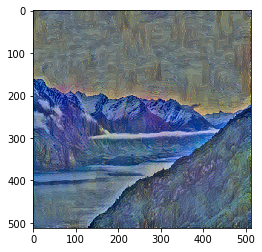

In [28]:
Image.fromarray(x)
imwrite('result.png', x)
plt.imshow(x)